# ECSE-551 Mini Project 3
Authors:
* Ashley Meagher (260822930)
* Charles Sirois (261158513)  
* Emma ()

In [92]:
# To specify where to load the data
in_colab = False

%load_ext autoreload
%autoreload 2

# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as pltà

import pickle
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Colab setup
if in_colab:
    folder_path = 'drive/MyDrive/Colab Notebooks/ECSE 551_MP3'

    from google.colab import drive
    from google.colab import data_table

    data_table.enable_dataframe_formatter()  # For interactive df viz

    drive.mount('/content/drive')

    #   # Import LogisticRegression
    #   import sys
    #   sys.path.insert(0, folder_path)
    #   from LogisticRegression import LogisticRegression

else:
    folder_path = 'MP3'

    # Our imports
    # from LogisticRegression import LogisticRegression, cost_function
    ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [101]:
class MyDataset(Dataset):
    """To load the pickled data file. Class from tutorial 6 of ECSE-551

    img_file: the pickle file containing the images
    label_file: the .csv file containing the labels
    transform: We use it for normalizing images (see above)
    idx: This is a binary vector that is useful for creating training and validation set.
    
    It return only samples where idx is True.

    Attributes
    ----------
    data
    targets
    transform
    
    """
    def __init__(self, img_file_name, label_file_name=None, transform=None, idx = None, folder_path=None):
        img_file_name = f"{folder_path}/{img_file_name}"
        
        with open(img_file_name, 'rb') as img_file:
            self.data = pickle.load(img_file, encoding='bytes')

        if label_file_name is not None:
            label_file = f"{folder_path}/{label_file_name}"

            # labels_df = pd.read_excel(label_file)
            # self.targets = labels_df['class'].to_numpy()
            
            self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:, 1:]
            
        else:
            self.targets = None

        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
          
        self.transform = transform

    def print_infos(self, img_idx=None):
        """To print information about the dataset.

        Shows image at img_idx or a random one if None.

        Args:
            img_idx (int, optional): Image to show. Defaults to None.
        """
        

        # General information
        print(f"Information about the dataset:")
        print(f"\tNumber of samples: {self.data.shape[0]}")
        print(f"\tFeature space: {self.data.shape[-2]}*{self.data.shape[-1]}")

        if self.targets is not None:
            classes, classes_count = np.unique(self.targets, return_counts=True)
            print(f"\tDifferent classes: {classes}. Their proportion: {classes_count/classes_count.sum()}")

        if img_idx is not None:
            print(f'Image {img_idx}')
            plt.imshow(self.data[img_idx, 0], cmap='gray', vmin=0, vmax=1)

        print()

    def __len__(self):
        if self.targets is not None:
            l = len(self.targets) 
        else:
            l = self.data.shape[0]
        return l

    def __getitem__(self, index):
        img = self.data[index][0]
        target = int(self.targets[index])

        if self.transform is not None:
            # img = Image.fromarray(img.astype('float'), mode='L')
            img_trans = self.transform(img)

        # If not transform specified, transform to torch tensor
        else:
            img_trans = transforms.ToTensor()(img)


        return img_trans, target
    

def show_image(img, vmin=0, vmax=1, ax=None):
    """To show the image

    Args:
        img (Image): Image to show
        vmin (int, optional): Min value of the scale. Defaults to 0.
        vmax (int, optional): Max value of the scale. Defaults to 1.
    """
    # plt.imshow(img.cpu().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
    
    if ax is not None:
        ax.imshow(img[0], cmap='gray', vmin=vmin, vmax=vmax)
        
    else:
        plt.imshow(img[0], cmap='gray', vmin=vmin, vmax=vmax)


# Load the dataset
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
# img_transform = None

data_folder = f"data"

train_file = 'Train.pkl'
train_label_file = 'Train_labels.csv'
test_file = 'Test.pkl'

# Datasets
no_transform_ds = MyDataset(train_file, label_file_name=train_label_file, transform=None, folder_path=data_folder)
train_ds = MyDataset(train_file, label_file_name=train_label_file, transform=img_transform, folder_path=data_folder)
test_ds = MyDataset(test_file, transform=img_transform, folder_path=data_folder)

train_ds.print_infos()
test_ds.print_infos()

Information about the dataset:
	Number of samples: 60000
	Feature space: 28*28
	Different classes: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]. Their proportion: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Information about the dataset:
	Number of samples: 10000
	Feature space: 28*28



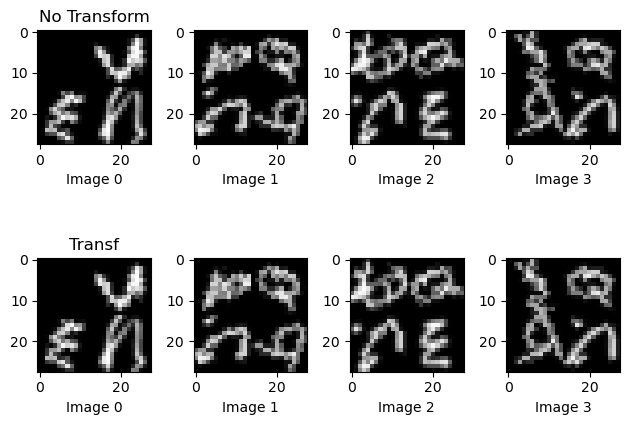

In [94]:
# Look a the first k images. Compare with and w/o transform
k = 4
fig, axes = plt.subplots(2, 4)
row_titles = ['No Transform', 'Transf']

for i, ax in enumerate(axes.flat):
    row = i // 4  # Calculate the row index
    col = i % 4  # Calculate the column index
    if row == 0:
        img, _ = no_transform_ds[col]
        vmin, vmax = 0, 1
    else:
        img, _ = train_ds[col]
        vmin, vmax = -1, 1

    show_image(img, ax=ax, vmin=vmin, vmax=vmax)

    if col == 0:
        ax.set_title(row_titles[row])  # Set row-wise title for the first image in each row
    ax.set_xlabel(f'Image {col}')  # Set individual title for each image

plt.tight_layout()
plt.show()

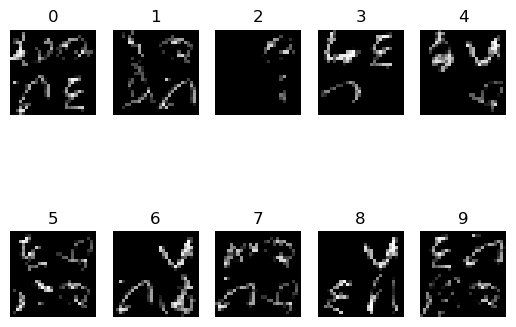

In [96]:
# Find the different labels
labels, labels_idx = np.unique(train_ds.targets, return_index=True)

fig = plt.figure()
plt.tight_layout()
for (i, label), idx in zip(enumerate(labels), labels_idx):
    # print(f'{i} {label} {idx}')
    img, target = train_ds[idx]

    ax = plt.subplot(2, 5, i + 1)
    ax.set_title(f'{target}')
    ax.axis('off')
    show_image(img)

plt.show()

In [107]:
# Dataloader
batch_size = 256 #feel free to change it
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# Example, to go through all samples
num_epochs=2 # Feel free to change it
for epoch in range(num_epochs):
    for train_data in train_dl: # train_data: One batch
        [img,label] = train_data  # img: Size batch_size x 1 x 28 x28, label: batch_size

# With my laptop: Takes 12 seconds to run 2 epoch w/ batch size of 256

## NN